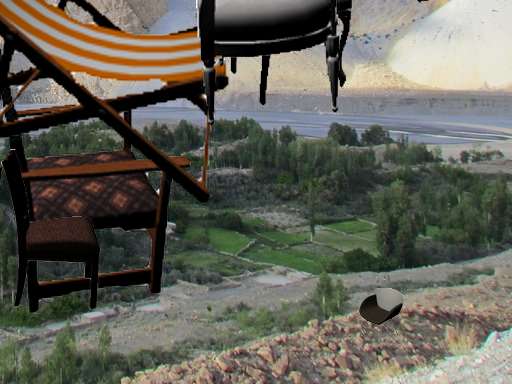

In [47]:
import numpy as np
from core.utils import frame_utils 
from PIL import Image
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"
img1 = frame_utils.read_gen("/home/xinyuanyu/data/FlyingChair_clean_flow/data/19020_img1.ppm")
img1 = np.array(img1).astype(np.uint8)
Image.fromarray(img1)

In [49]:
img1 = torch.from_numpy(img1).permute(2, 0, 1).float()

In [52]:
m = torch.nn.Upsample(scale_factor=0.5, mode='bilinear')
img1 = m(img1)[0]

/home/xinyuanyu/anaconda3/envs/raft/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/xinyuanyu/anaconda3/envs/raft/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [53]:
img1.shape

torch.Size([3, 192, 256])

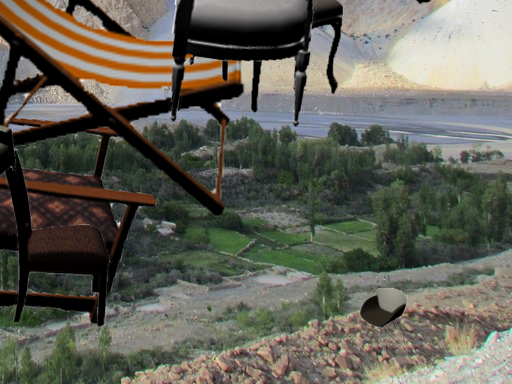

In [54]:
img2 = frame_utils.read_gen("/home/xinyuanyu/data/FlyingChair_clean_flow/data/19020_img2.ppm")
img2 = np.array(img2).astype(np.uint8)
Image.fromarray(img2)

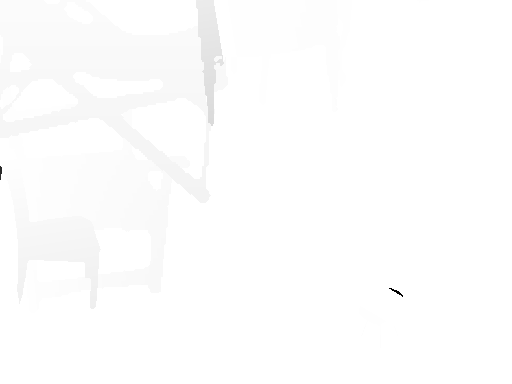

In [55]:
flow = frame_utils.read_gen("/home/xinyuanyu/data/FlyingChair_clean_flow/data/19020_flow.flo")
flow = np.array(flow).astype(np.uint8)
Image.fromarray(flow)

In [4]:
import sys
sys.path.append('core')

import argparse
import os
import cv2
import glob
import numpy as np
import torch
from PIL import Image

from raft import RAFT
from utils import flow_viz
from utils.utils import InputPadder

In [56]:
flow.shape

(384, 512, 2)

In [5]:
DEVICE = 'cuda'

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', help="restore checkpoint")
parser.add_argument('--path', help="dataset for evaluation")
parser.add_argument('--small', action='store_true', help='use small model')
parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
parser.add_argument('--alternate_corr', action='store_true', help='use efficent correlation implementation')
args = parser.parse_args(args=['--model', 'models/raft-things.pth', '--path', 'demo-frames'])

In [7]:
model = torch.nn.DataParallel(RAFT(args))
model.load_state_dict(torch.load(args.model))
model = model.module
model.to(DEVICE)
model.eval()

RAFT(
  (fnet): BasicEncoder(
    (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (relu1): ReLU(inplace=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu): ReLU(inplace=True)
        (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=Fa

In [8]:
def load_image(imfile):
    img = np.array(Image.open(imfile)).astype(np.uint8)
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    return img[None].to(DEVICE)

In [9]:
images = glob.glob(os.path.join(args.path, '*.png')) + \
                 glob.glob(os.path.join(args.path, '*.jpg'))
images = sorted(images)

In [20]:
image1 = load_image('demo-frames/frame_0016.png')
image2 = load_image('demo-frames/frame_0025.png')

In [21]:
image1.size()

torch.Size([1, 3, 436, 1024])

In [22]:
padder = InputPadder(image1.shape)
image1, image2 = padder.pad(image1, image2)

In [23]:
image1.size()

torch.Size([1, 3, 440, 1024])

In [24]:
# flow_low, flow_up = model(image1, image2, iters=20, test_mode=True)
flow_prediction = model(image1, image2, iters=20, test_mode=True)

In [25]:
len(flow_prediction)

2

In [26]:
def viz(img, flo):
    img = img[0].permute(1,2,0).cpu().detach().numpy()
    flo = flo[0].permute(1,2,0).cpu().detach().numpy()
    
    # map flow to rgb image
    flo = flow_viz.flow_to_image(flo)
    img_flo = np.concatenate([img, flo], axis=0)

    import matplotlib.pyplot as plt
    plt.imshow(img_flo) 
    plt.show()


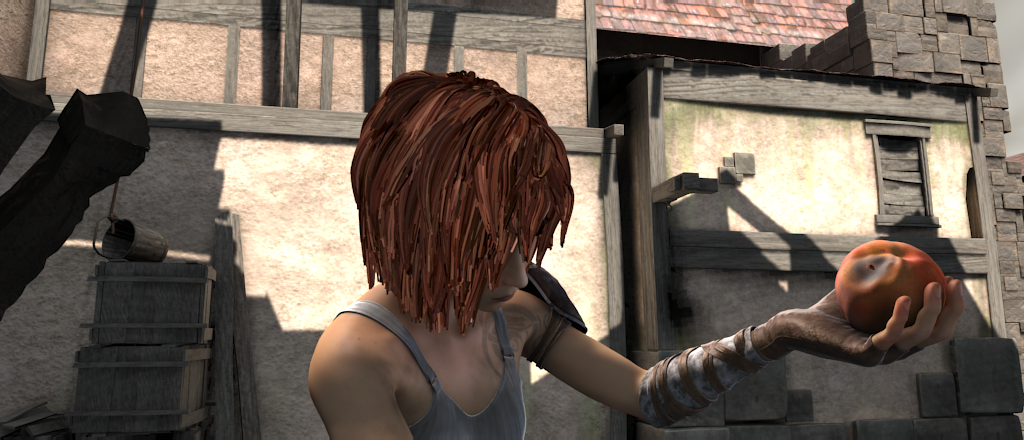

In [27]:
img1 = image1[0].permute(1,2,0).cpu().detach().numpy()
Image.fromarray((img1).astype(np.uint8))

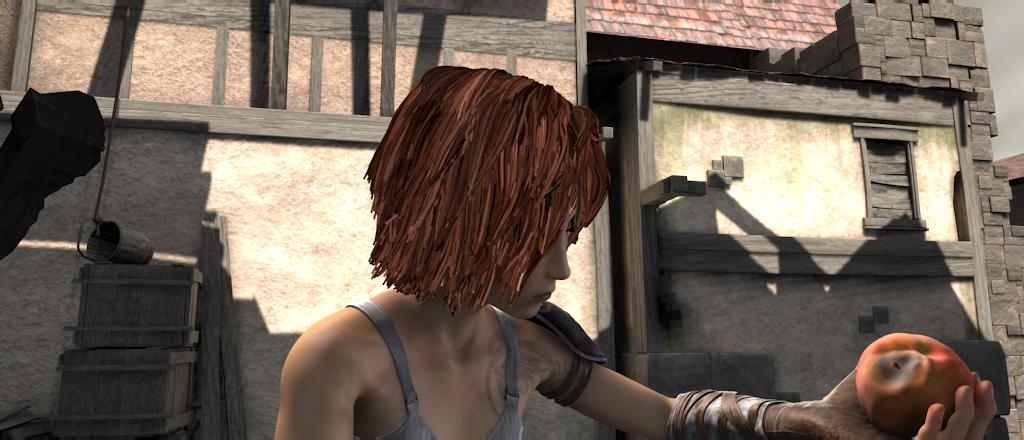

In [28]:
img2 = image2[0].permute(1,2,0).cpu().detach().numpy()
Image.fromarray((img2).astype(np.uint8))

In [42]:
flow_warp

<module 'utils.flow_warp' from 'core/utils/flow_warp.py'>

In [45]:
image2_warp = flow_warp.flow_warp(image2, flow_prediction[1].permute(0, 2, 3, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


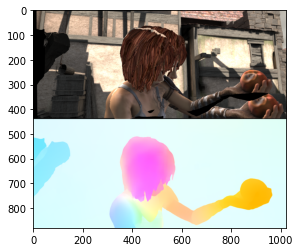

In [46]:
viz(image2_warp, flow_prediction[1])

In [30]:
flow_prediction[1].shape

torch.Size([1, 2, 440, 1024])

In [17]:
for i in range(len(flow_prediction)):
    viz(image1, flow_prediction[i])
# flow_prediction[0].shape

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1024 and the array at index 1 has size 128

In [ ]:
viz(image2, flow_low)

In [ ]:
try:
    autocast = torch.cuda.amp.autocast
except:
    # dummy autocast for PyTorch < 1.6
    class autocast:
        def __init__(self, enabled):
            pass
        def __enter__(self):
            pass
        def __exit__(self, *args):
            pass

In [ ]:
image1 = 2 * (image1 / 255.0) - 1.0
image2 = 2 * (image2 / 255.0) - 1.0
with autocast(enabled=model.args.mixed_precision):
    fmap1, fmap2 = model.fnet([image1, image2])        

fmap1 = fmap1.float()
fmap2 = fmap2.float()

In [ ]:
from update import BasicUpdateBlock, SmallUpdateBlock
from extractor import BasicEncoder, SmallEncoder
from corr import CorrBlock, AlternateCorrBlock
from utils.utils import bilinear_sampler, coords_grid, upflow8
corr_fn = CorrBlock(fmap1, fmap2, radius=model.args.corr_radius)

In [ ]:
cnet = model.cnet(image1)
cnet.size()

In [ ]:
hdim = model.hidden_dim
cdim = model.context_dim

In [ ]:
net, inp = torch.split(cnet, [hdim, cdim], dim=1)
net = torch.tanh(net)
inp = torch.relu(inp)

In [ ]:
coords0, coords1 = model.initialize_flow(image1)

In [ ]:
coords1 = coords1.detach()
corr = corr_fn(coords1)

In [ ]:
corr = corr_fn(coords1)

In [ ]:
corr.shape

In [ ]:
flow.shape

In [ ]:
coords1

In [ ]:
fmap1 = fmap1.view(1, 256, 55*128)
fmap2 = fmap2.view(1, 256, 55*128)
corr = torch.matmul(fmap1.transpose(1,2), fmap2)

In [ ]:
corr.shape

In [ ]:
coords1.permute(0, 2, 3, 1).shape

In [ ]:
r = 4
dx = torch.linspace(-r, r, 2*r+1, device=coords1.device)
dy = torch.linspace(-r, r, 2*r+1, device=coords1.device)
delta = torch.stack(torch.meshgrid(dy, dx), axis=-1)

In [ ]:
centroid_lvl = coords1.reshape(1*55*128, 1, 1, 2)
delta_lvl = delta.view(1, 2*r+1, 2*r+1, 2)
coords_lvl = centroid_lvl + delta_lvl

In [ ]:
corr = corr_fn.corr_pyramid[0]

In [ ]:
corr.shape

In [ ]:
corr = bilinear_sampler(corr, coords_lvl)

In [ ]:
corr.shape

In [ ]:
corr = corr.view(1, 55, 128, -1)